In [1]:
#导入依赖库
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import math
import numpy as np

In [2]:
#读取数据表格
data = pd.read_excel(r'D:\BaiduNetdiskDownload\机器学习录播资料\2022.7 机器学习材料代码\data.xlsx')
print(data)
#输入特征X(从0计，第2列及以后)
X = data.iloc[:,2:]
#自动拼接成描述符
X = X.to_numpy()
print(X)
#标签Y(第1列)
Y = data.iloc[:,1]
Y = Y.to_numpy()
print(Y)
#数据标准化(可能提高模型性能，注释该部分代码以跳过)
X = StandardScaler().fit_transform(X)

    Alloy system  ΔE*CO     f    ed    Wd    γ1     γ2     W    r0    rd  \
0          Ni@Cu  -0.69  0.97 -2.21  1.11  1.08   8.87  5.30  1.41  0.67   
1          Cu@Cu  -0.63  0.97 -2.25  1.05  1.13  10.94  5.30  1.41  0.67   
2          Pd@Cu  -0.86  0.98 -1.66  0.97  0.47   8.60  5.30  1.41  0.67   
3          Ag@Cu  -0.74  0.98 -1.90  0.88  0.06  15.15  5.30  1.41  0.67   
4          Ir@Cu  -0.91  0.97 -2.10  1.13  0.26   8.42  5.30  1.41  0.67   
..           ...    ...   ...   ...   ...   ...    ...   ...   ...   ...   
293     Pt3Pt@Pt  -1.70  0.88 -2.03  1.87  0.17   3.65  6.74  1.53  1.04   
294     Pt3Au@Pt  -1.72  0.89 -1.80  1.77  0.13   4.01  6.74  1.53  1.04   
295     Pt3Tl@Pt  -1.56  0.89 -1.77  1.76 -0.30   7.25  6.74  1.53  1.04   
296     Pt3Pb@Pt  -1.43  0.90 -1.81  1.69  0.02   5.88  6.74  1.53  1.04   
297     Pt3Bi@Pt  -1.46  0.90 -1.91  1.73 -0.22   7.63  6.74  1.53  1.04   

       IE    EA  chi0   chi  Vad2  
0    7.73  1.24  1.90  1.90   1.0  
1    7.73  1.24

In [4]:
#超参数设置可能不合理，训练中会出现警告信息，可以忽略掉(如不忽略请注释掉代码)
import warnings
warnings.filterwarnings("ignore")
#构建模型
#参考文献超参数 2个隐藏层 第1隐藏层维度5 第2层维度2,激活函数sigmoid(logistic)
#sklearn架构的回归神经网络只使用均方误差损失函数
model = MLPRegressor()
#设定可调超参数空间(层 激活函数 学习率 迭代次数)(自行尝试引入更多参数)
#hidden_layer_sizes:各层特征维度，元组长度即层数
#使用自动batch_size=min(200, n_samples)
tuned_parameters = [
    {"hidden_layer_sizes": [(5,),(5,2),(5,5,2)], "activation":["relu","logistic","tanh"],
     "learning_rate_init":[0.001,0.01,0.1],"max_iter":[200,300,400]
    },]

#构建相应的交叉验证超参搜索器(这里使用网格搜索) 使用平均误差MAE的负数作为评分指标
#10-FOLD
clf = GridSearchCV(model, tuned_parameters, scoring="neg_mean_absolute_error", cv=10)
#反复训练并搜索最佳超参
clf.fit(X,Y)
#输出结果(指标用MAE)
print("当前数据集上的最佳模型超参数设置:")
print(clf.best_params_)
print("相应评分：")
print("%0.3f eV" %(-clf.best_score_))
print()
print("各超参数设置及相应模型评分(评分/±标准差):")
means = -clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
    print("%0.3f eV (+/-%0.03f eV) for %r" % (mean, std * 2, params))
    
#可以绘制其他超参不变，模型性能随超参的变化
#还可以绘制特征重要性

当前数据集上的最佳模型超参数设置:
{'activation': 'logistic', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1, 'max_iter': 300}
相应评分：
0.101 eV

各超参数设置及相应模型评分(评分/±标准差):
0.441 eV (+/-0.894 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.001, 'max_iter': 200}
0.258 eV (+/-0.361 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.001, 'max_iter': 300}
0.314 eV (+/-0.599 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.001, 'max_iter': 400}
0.141 eV (+/-0.143 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01, 'max_iter': 200}
0.134 eV (+/-0.142 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01, 'max_iter': 300}
0.145 eV (+/-0.127 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.01, 'max_iter': 400}
0.119 eV (+/-0.098 eV) for {'activation': 'relu', 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.

(-2.0, 0.2)

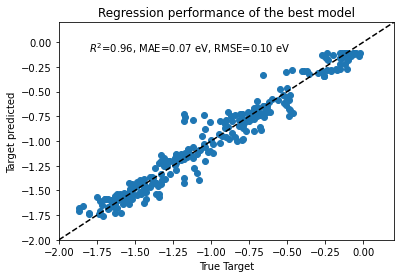

In [5]:
#可视化交叉验证得到的最优模型在整个数据集上的性能

#获取最优模型
best_model = clf.best_estimator_
#预测
Y_pred = best_model.predict(X)
#绘制
fig, ax = plt.subplots()
#绘制预测-真值对散点
ax.scatter(Y,Y_pred)
#绘制对角线
ax.plot([-2,0.2], [-2,0.2], "--k")
ax.set_ylabel("Target predicted")
ax.set_xlabel("True Target")
ax.set_title("Regression performance of the best model")
#计算决定系数R2,MAE以及RMSE作为图注
ax.text(
    -1.8,
    -0.1,
    r"$R^2$=%.2f, MAE=%.2f eV, RMSE=%.2f eV"
    % (r2_score(Y, Y_pred), mean_absolute_error(Y, Y_pred), math.sqrt(mean_squared_error(Y, Y_pred))),
)
#x y轴上下限
ax.set_xlim([-2,0.2])
ax.set_ylim([-2,0.2])

(-2.0, 0.2)

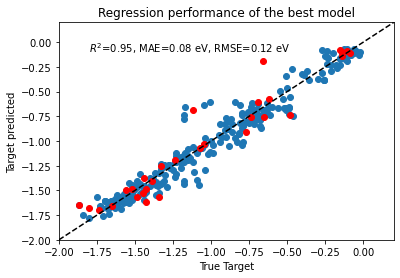

In [6]:
#基于最优参数再单独训练一个新模型，进行一次留一验证，测试集比例0.1
from sklearn.model_selection import train_test_split
#分配训练集，验证集
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
#基于最优参数训练新模型
model = MLPRegressor(**clf.best_params_)
model.fit(X_train, y_train)

#分别预测
Y_pred = model.predict(X)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
#绘制
fig, ax = plt.subplots()
#绘制预测-真值对散点
#训练集数据点
ax.scatter(y_train,y_train_pred)
#测试集数据点(红色)
ax.scatter(y_test,y_test_pred,color='r')
#绘制对角线
ax.plot([-2,0.2], [-2,0.2], "--k")
ax.set_ylabel("Target predicted")
ax.set_xlabel("True Target")
ax.set_title("Regression performance of the best model")
#计算决定系数R2和MAE作为图注
ax.text(
    -1.8,
    -0.1,
    r"$R^2$=%.2f, MAE=%.2f eV, RMSE=%.2f eV"
    % (r2_score(Y, Y_pred), mean_absolute_error(Y, Y_pred), math.sqrt(mean_squared_error(Y, Y_pred))),
)
#x y轴上下限
ax.set_xlim([-2,0.2])
ax.set_ylim([-2,0.2])

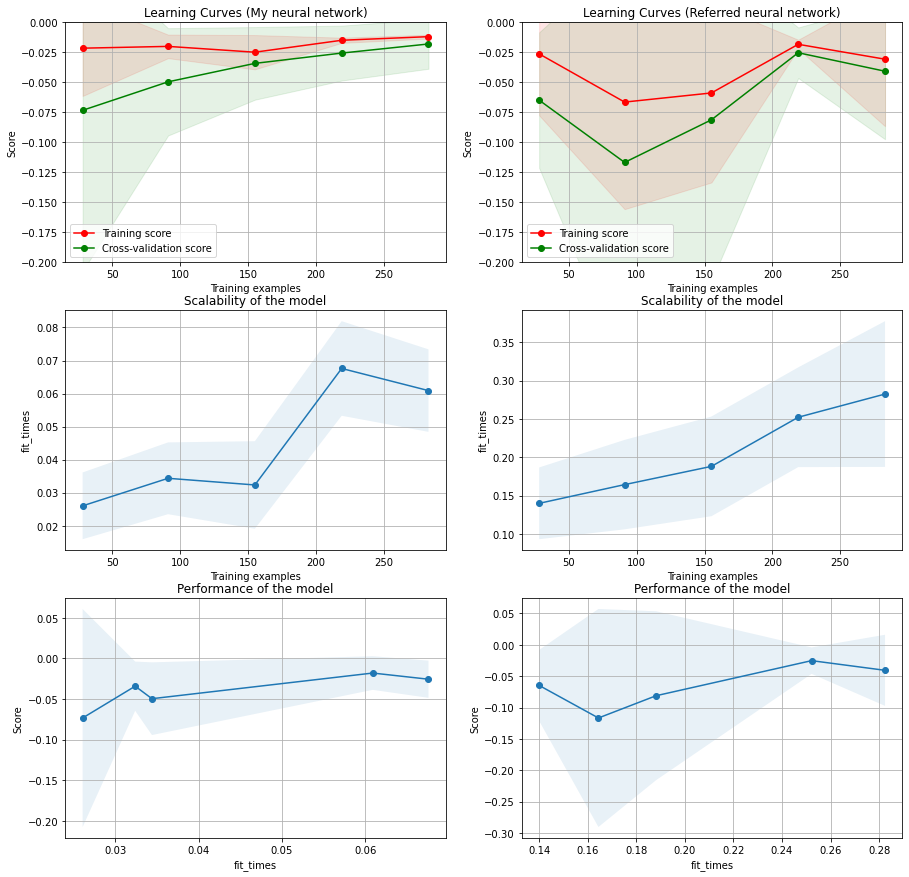

In [6]:
#用多种可视化曲线更全面地对比我们的最优模型和文献中的模型

#自定义绘制曲线的方法
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    score="neg_mean_squared_error",
    axes=None,
    ylim=None,
    cv=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    绘制3种曲线: 学习曲线, 训练样本数-拟合时间曲线, 拟合时间-分数曲线.(拟合时间可以看作epoch数)

    参数
    ----------
    estimator : 模型

    title : 曲线图标题

    X : 输入描述符

    y : 标签
    
    score :使用的评分指标 默认使用MSE的负数，越正越好

    axes : 用于绘制曲线的坐标轴(三个)

    ylim : 设定图中纵轴的上下限 (ymin, ymax).

    cv : 交叉验证参数 如传入整数k即进行k-fold交叉验证 也可直接传入已定义的样本分配(如ShuffleSplit)

    train_sizes : 使用的训练样本数量或占数据集比例(对应横轴刻度)
    """

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    #使用learning_curve()方法，可自动交叉验证并返回各种统计信息
    #训练使用的训练集数目逐次增加
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        scoring=score,
        train_sizes=train_sizes,
        return_times=True,
    )
    #计算性能指标平均值和标准差
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    #绘制学习曲线
    #绘制网格
    axes[0].grid()
    #指标波动范围(指标标准差，反映模型稳定性，或说泛化能力)
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    #以指标均值绘制曲线
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    #图例
    axes[0].legend(loc="best")

    #绘制训练样本数-拟合时间曲线
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    #绘制拟合时间-分数曲线
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
#3行2列
#如果各图有重叠或靠的太近 自行调大figsize的宽高
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

#自定义样本分配
#cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

title = "Learning Curves (My neural network)"

#使用我们自己搜索到的最佳超参
estimator = MLPRegressor(**clf.best_params_)
#绘制3种曲线 如果纵轴范围不合理 则自行调整ylim
#建议使用较大的交叉验证次数(cv)，以减小每次测试平均指标的不确定性，有利于曲线平滑
plot_learning_curve(
    estimator, title, X, Y, axes=axes[:, 0], ylim=(-0.2, 0), cv=20,
)

title = r"Learning Curves (Referred neural network)"
#使用文献中的超参数
estimator = MLPRegressor(activation='logistic',hidden_layer_sizes=(5,5,2),learning_rate_init=0.01,max_iter=300)
#绘制3种曲线
plot_learning_curve(
    estimator, title, X, Y, axes=axes[:, 1], ylim=(-0.2, 0), cv=20,
)

plt.show()
#可以看到无论是在指标的平均值还是标准差上，我们自己找到的超参数比文献中提供的更好(文献使用了较老的机器学习库)